In [135]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from surprise.model_selection import train_test_split as ttsplit
import gcsfs
from surprise import accuracy
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor

# Welcome to the Netflix recommender tutorial!

In this tutorial we are going to explore the Netflix dataset from the Netflix prize competition https://www.netflixprize.com/. This competition had $ 1 million dollars in prize money.

Recommendations are essential in Netflix, better recommendation improve the customer experience and improving these recommendations will eventually result in profits.

The dataset is very big, there are  initially it might look simple but there are quite some interesting aspects you have to take into account when creating an effective recommendation model. We have 480000 customers in the dataset and already 24 million ratings in just a segment of the dataset. 

As it is quite hard to work with the complete dataset we are going to work with a subset of 24M ratings in this tutorial, which is already a big dataset.

# Data loading

## Ratings

In [2]:
# Skip date
df = pd.read_csv('gs://codequarantine-tutorials/netflix/input/combined_data_1.txt', 
                  header = None, 
                  names = ['Cust_Id', 'Rating', 'date'], 
                  usecols = [0,1,2])

df['Rating'] = df['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Dataset 1 shape: (24058263, 3)
-Dataset examples-
          Cust_Id  Rating        date
0              1:     NaN         NaN
5000000   2560324     4.0  2005-12-06
10000000  2271935     2.0  2005-04-11
15000000  1921803     2.0  2005-01-31
20000000  1933327     3.0  2004-11-10


In [3]:
df_nan = df[df.Rating.isna()].copy()

In [4]:
df_nan['movie_id'] = df_nan['Cust_Id']

In [5]:
df.loc[df_nan.index, 'movie_id'] = df_nan['movie_id']

In [6]:
df.movie_id.ffill(inplace=True)

In [7]:
df.dropna(inplace=True)

In [8]:
df['movie_id'] = df.movie_id.str.replace(':', '')

In [9]:
df['movie_id'] = df.movie_id.astype(int)

In [10]:
np.random.seed(0)
sample = np.random.choice(df.movie_id.unique(), 2000)

In [11]:
df = df[df.movie_id.isin(sample)]

In [12]:
df['date'] = pd.to_datetime(df['date'])

In [13]:
df['month_year'] = df.date.dt.to_period('M')

In [14]:
df['weekday'] = df.date.dt.weekday

## Movie titles

We have a separate movie title dataset. The movie id's correspond to the movie id's in the rating dataset. 

In [15]:
df_titles = pd.read_csv('gs://codequarantine-tutorials/netflix/input/movie_titles.csv',
                        header=None,
                        usecols=[0,1,2],
                        names=['movie_id', 'year', 'title'],
                        encoding = "ISO-8859-1")

In [16]:
df_titles

movie_id    year                                              title
0             1  2003.0                                    Dinosaur Planet
1             2  2004.0                         Isle of Man TT 2004 Review
2             3  1997.0                                          Character
3             4  1994.0                       Paula Abdul's Get Up & Dance
4             5  2004.0                           The Rise and Fall of ECW
5             6  1997.0                                               Sick
6             7  1992.0                                              8 Man
7             8  2004.0                         What the #$*! Do We Know!?
8             9  1991.0                           Class of Nuke 'Em High 2
9            10  2001.0                                            Fighter
10           11  1999.0                     Full Frame: Documentary Shorts
11           12  1947.0                               My Favorite Brunette
12           13  2003.0  Lord of the Rings: The Return of the King: Ext...
13           14  1982.0                                 Nature: Antarctica
14           15  1988.0                   Neil Diamond: Greatest Hits Live
15           16  1996.0                                          Screamers
16           17  2005.0                                          7 Seconds
17           18  1994.0                                   Immortal Beloved
18           19  2000.0                              By Dawn's Early Light
19           20  1972.0                                    Seeta Aur Geeta
20           21  2002.0                                  Strange Relations
21           22  2000.0                                       Chump Change
22           23  2001.0  Clifford: Clifford Saves the Day! / Clifford's...
23           24  1981.0                                My Bloody Valentine
24           25  1997.0      Inspector Morse 31: Death Is Now My Neighbour
25           26  2004.0                                    Never Die Alone
26           27  1962.0  Sesame Street: Elmo's World: The Street We Liv...
27           28  2002.0                                    Lilo and Stitch
28           29  2001.0                                            Boycott
29           30  2003.0                             Something's Gotta Give
...         ...     ...                                                ...
17740     17741  2004.0                          Ginger Snaps 2: Unleashed
17741     17742  1995.0                                Catherine the Great
17742     17743  2003.0                               Better Luck Tomorrow
17743     17744  2004.0                         NASCAR: Tony Stewart Smoke
17744     17745  2002.0      Russell Simmons Presents Def Poetry: Season 1
17745     17746  1991.0  Godzilla & Mothra: Battle for Earth / Vs. King...
17746     17747  1991.0                            Eric Clapton: 24 Nights
17747     17748  2005.0        Dog the Bounty Hunter: The Best of Season 1
17748     17749  1985.0                                             No End
17749     17750  2005.0                     The Hee Haw Collection: Vol. 4
17750     17751  1993.0                               Highlander: Season 2
17751     17752  2003.0                                       Out of Order
17752     17753  1997.0                                       Maslin Beach
17753     17754  1999.0                                       On the Ropes
17754     17755  2003.0                           L/R: Licensed by Royalty
17755     17756  1935.0                                       The 39 Steps
17756     17757  2002.0  Ulysses S. Grant: Warrior / President: America...
17757     17758  1979.0                                           Prophecy
17758     17759  1972.0                                  The Big Bird Cage
17759     17760  2004.0                                      Lightning Bug
17760     17761  2003.0                                             Levity
17761     17762  1997.0         

# Data exploration

In [17]:
# Check structure of the dataset
df.head()

Cust_Id  Rating       date  movie_id month_year  weekday
1  1488844     3.0 2005-09-06         1    2005-09        1
2   822109     5.0 2005-05-13         1    2005-05        4
3   885013     4.0 2005-10-19         1    2005-10        2
4    30878     4.0 2005-12-26         1    2005-12        0
5   823519     3.0 2004-05-03         1    2004-05        0

In [18]:
df.tail()

Cust_Id  Rating       date  movie_id month_year  weekday
24057829  1184587     2.0 2004-11-02      4498    2004-11        1
24057830  2349702     3.0 2002-07-22      4498    2002-07        0
24057831  1174376     3.0 2005-03-03      4498    2005-03        3
24057832  1305108     3.0 2002-02-03      4498    2002-02        6
24057833  1766524     2.0 2004-05-04      4498    2004-05        1

In [19]:
# That's a lot of rows!
df.shape

(9347773, 6)

In [20]:
# Check number of unique users
df.Cust_Id.unique().shape

(450338,)

In [21]:
# Check number of unique movies
df.movie_id.unique().shape

(1599,)

In [22]:
# Check average rating, it's quite high 
df.Rating.mean()

3.640935012007673

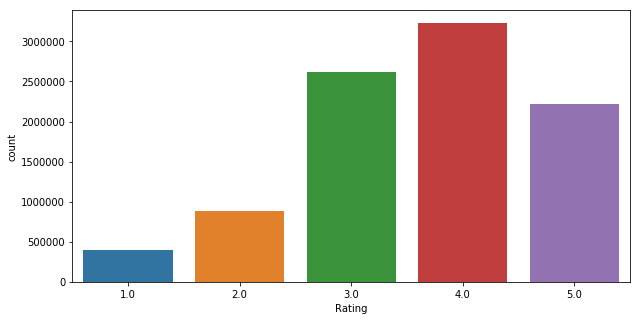

In [23]:
# Count individual ratings
plt.figure(figsize=(10,5))
sns.countplot('Rating', data=df)

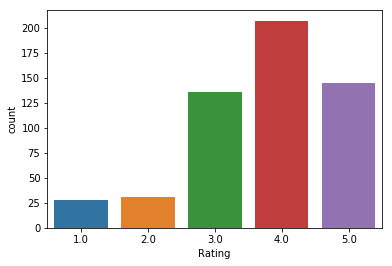

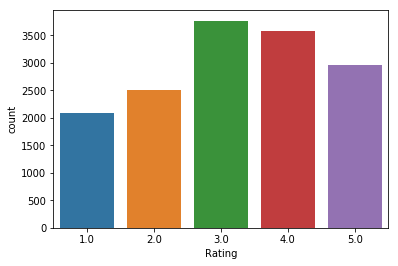

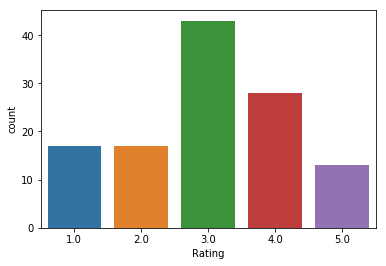

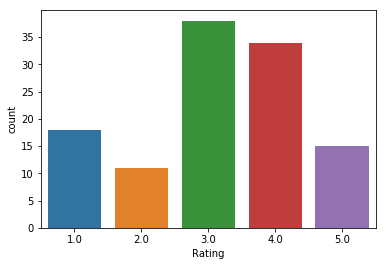

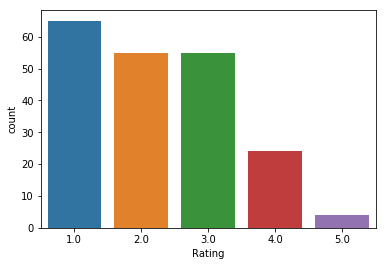

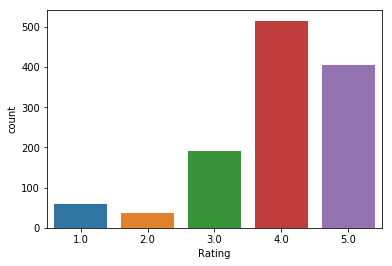

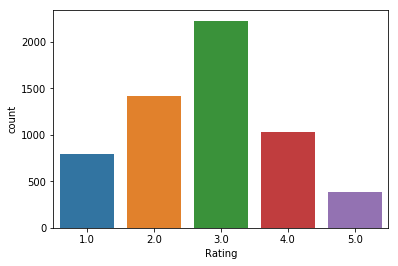

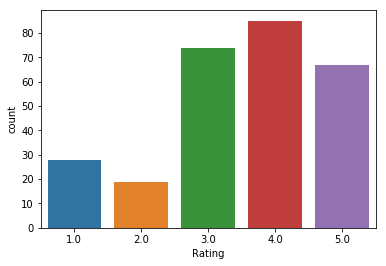

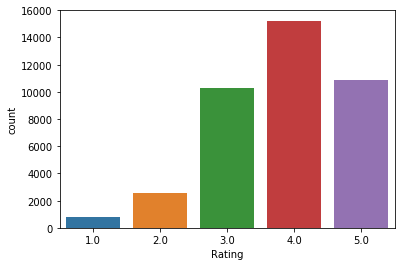

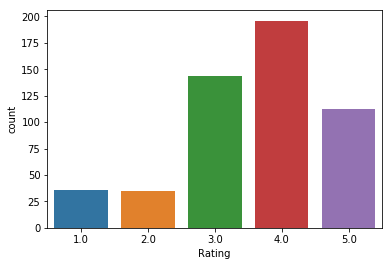

In [24]:
# Check ratings for some movies
for i in df.movie_id.unique()[0:10]:
    plt.figure()
    sns.countplot('Rating', data=df[df.movie_id == i])

In [25]:
# Count number of ratings for each movie
counts = df.groupby(['movie_id']).Rating.count().reset_index()
counts.columns = ['movie_id', 'movie_rating_count']
df = pd.merge(df, counts, on='movie_id')

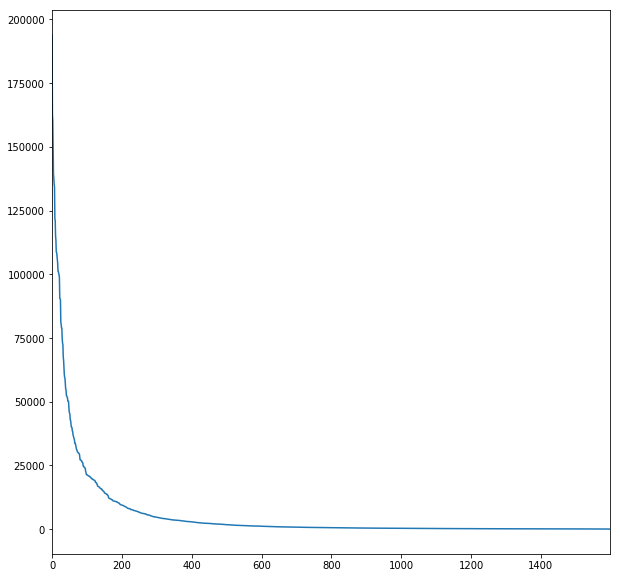

In [26]:
counts.sort_values('movie_rating_count', ascending=False).reset_index().movie_rating_count.plot(figsize=(10,10))

We can see that some movies are rated much much more then others

# Exercise: data exploration!

- Try to understand the exploratory data analysis I have made so far
- Try to visualize more aspects of the data

Hints:

- What is the most popular movie?
- Do users rate different when they have rated more movies?

# Base model(s)

In [27]:
train, test = train_test_split(df, random_state=1)

In [28]:
def add_mean_all_movies(train, test):
    """
    Add a column with the average rating of all ratings
    """
    mean = train.Rating.mean()
    train['mean_rating_overall'] = mean
    test['mean_rating_overall'] = mean

In [29]:
def add_customer_avg_rating(train, test):
    """
    Add column with average rating from a customer
    """
    grouped = train.groupby('Cust_Id').Rating.mean()
    grouped = grouped.reset_index()
    grouped.columns = ['Cust_Id', 'customer_avg_rating']
    train = pd.merge(train, grouped, on='Cust_Id')
    test = pd.merge(test, grouped, on='Cust_Id')
    return train, test

In [30]:
def create_features(df):
    train, test = train_test_split(df, random_state=1)
    train = train.copy()
    test = test.copy()
    add_mean_all_movies(train, test)
    train, test = add_customer_avg_rating(train, test)
    return train, test
train, test = create_features(df)

In [31]:
del df

In [32]:
print(mse(train['Rating'], train['mean_rating_overall'], squared=False))
print(mse(test['Rating'], test['mean_rating_overall'], squared=False))

1.070256272709857
1.0700970375322698


In [34]:
print(mae(train['Rating'], train['mean_rating_overall']))
print(mae(test['Rating'], test['mean_rating_overall']))

0.8923704898109885
0.8921569457716185


In [33]:
print(mse(train['Rating'], train['customer_avg_rating'], squared=False))
print(mse(test['Rating'], test['customer_avg_rating'], squared=False))

0.9481614002907047
1.016354573529923


# Exercise: try to figure out more base models

Hints:

- Movie based mean model?
- Day of week mean model?
- Mean based on the current mean at time of rating?
- Other?


# Further preprocessing

In [35]:
optimization_var = 'Rating'
reader = Reader(rating_scale=(min(train[optimization_var]), max(train[optimization_var])))
traindata = Dataset.load_from_df(train[['Cust_Id', 'movie_id', optimization_var]][:], reader).build_full_trainset()
testdata = Dataset.load_from_df(test[['Cust_Id', 'movie_id',  optimization_var]][:], reader).build_full_trainset().build_testset()

# KNN Collaborative filtering - Item based

KNN collaborative filtering will determine the similarity between each item based on the users feedback. It will use the K nearest neighbours (most similar items) to predict the users preference. 

In [36]:
# Initialize KNN
algo = KNNBasic(k=15, verbose=True, sim_options={'user_based': False, 'name': 'pearson'})

In [37]:
# Fit model
algo.fit(traindata)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [38]:
# Make predictions and test root mean squared error on test set
predictions_test = algo.test(testdata)
accuracy.rmse(predictions_test)

RMSE: 0.9815


0.9814761414031085

In [39]:
# Calculate mean absolute error on test set
accuracy.mae(predictions_test)

MAE:  0.7687


0.768653743709147

In [40]:
train

Cust_Id  Rating       date  movie_id month_year  weekday  \
0        1783158     3.0 2004-07-05       101    2004-07        0   
1        1783158     4.0 2004-11-30      2252    2004-11        1   
2        1783158     4.0 2005-05-04       282    2005-05        2   
3        1783158     4.0 2004-10-26       607    2004-10        1   
4        1783158     3.0 2005-08-05      3624    2005-08        4   
5        1783158     2.0 2005-08-19      3414    2005-08        4   
6        1783158     3.0 2005-09-02      2234    2005-09        4   
7        1783158     3.0 2005-04-24      3138    2005-04        6   
8        1783158     4.0 2004-12-05      3495    2004-12        6   
9        1783158     3.0 2005-11-27       831    2005-11        6   
10       1783158     3.0 2005-09-16      1499    2005-09        4   
11       1783158     5.0 2004-05-19      1905    2004-05        2   
12       1783158     3.0 2004-07-23      4135    2004-07        4   
13       1783158     5.0 2004-05-14      1542    2004-05        4   
14       1783158     4.0 2004-11-05      4330    2004-11        4   
15       1783158     4.0 2004-11-30      1467    2004-11        1   
16       1783158     5.0 2004-05-20      1741    2004-05        3   
17       1783158     1.0 2005-11-20      1691    2005-11        6   
18       1783158     4.0 2004-12-29      3025    2004-12        2   
19       1783158     2.0 2005-09-30       425    2005-09        4   
20       1783158     2.0 2005-05-26      3442    2005-05        3   
21       1783158     3.0 2004-05-20      1599    2004-05        3   
22       1783158     5.0 2004-11-30      2097    2004-11        1   
23       1783158     3.0 2004-06-01      2057    2004-06        1   
24       1783158     2.0 2005-09-30      2928    2005-09        4   
25       1783158     2.0 2005-10-15      4041    2005-10        5   
26       1783158     2.0 2005-06-01      1139    2005-06        2   
27       1783158     1.0 2004-05-19      1902    2004-05        2   
28       1783158     5.0 2004-05-14      1798    2004-05        4   
29       1783158     3.0 2004-06-28       257    2004-06        0   
...          ...     ...        ...       ...        ...      ...   
7010799  1212537     4.0 2004-11-06      2342    2004-11        5   
7010800  2130261     4.0 2004-12-06       175    2004-12        0   
7010801  1136557     4.0 2005-10-19      1905    2005-10        2   
7010802  1013001     2.0 2005-01-04      4384    2005-01        1   
7010803  1717906     4.0 2005-09-05      1974    2005-09        0   
7010804  2493801     3.0 2005-09-09      1307    2005-09        4   
7010805   282107     4.0 2005-07-09      1307    2005-07        5   
7010806   739595     1.0 2005-10-05      2122    2005-10        2   
7010807    90261     4.0 2005-10-13      2342    2005-10        3   
7010808   881385     3.0 2005-12-12      3860    2005-12        0   
7010809  1232732     4.0 2005-11-01      2372    2005-11        1   
7010810  1296377     4.0 2004-05-28      1470    2004-05        4   
7010811  1744718     2.0 2004-03-03      3860    2004-03        2   
7010812   643891     5.0 2005-09-06      1470    2005-09        1   
7010813   239992     4.0 2004-08-16      3570    2004-08        0   
7010814  1941164     4.0 2005-12-31      1292    2005-12        5   
7010815  1878302     5.0 2004-11-09      1220    2004-11        1   
7010816  1996329     3.0 2005-11-14      3864    2005-11        0   
7010817  2348731     5.0 2005-09-06      2152    2005-09        1   
7010818  2088480     3.0 2005-11-17      3605    2005-11        3   
7010819  2370543     3.0 2005-05-27      1632    2005-05        4   
7010820   176274     4.0 2004-04-26      3347    2004-04        0   
7010821   615009     2.0 2004-01-11      1307    2004-01        6   
7010822  1733875     4.0 2004-01-06      2780    2004-01        1   
7010823   845905     3.0 2003-11-13      1027    2003-11        3   
7010824   779446     5.0 2005-06-16      1307    2005-06        3   
7010825

In [41]:
# Check movie id
df_titles.loc[df_titles['movie_id'] == 3456]['title'].values[0]

'Lost: Season 1'

In [42]:
def print_similar_movies(algo, movie_id, movie_titles, nr_recommendations):
    """
    Print similar movies based on the KNN model
    """
    recommendations = algo.get_neighbors(traindata.to_inner_iid(movie_id), nr_recommendations)
    for r in recommendations:
        rec_title = df_titles.loc[df_titles['movie_id'] == r]['title'].values[0]
        print(rec_title)

In [43]:
print_similar_movies(algo, 2117, df_titles, 10)

A Yank in the R.A.F.
ECW: Cyberslam '99
Silk Stockings
Lucio Fulci: The Beyond
Lost in the Wild
Demon Warrior Koji
Pressure
Peter Tosh: Stepping Razor: Red X
Gupt
Home Movie


In [51]:
# Add test predictions to test dataset
preds = pd.DataFrame(predictions_test)[['uid', 'iid', 'est']]
del predictions_test
preds.columns = ['Cust_Id', 'movie_id', 'knn_preds']
test = pd.merge(test, preds, on=['Cust_Id', 'movie_id'])

In [44]:
# Add train predictions to train dataset
traindata_formatted = Dataset.load_from_df(train[['Cust_Id', 'movie_id', optimization_var]][:], reader).build_full_trainset().build_testset()

predictions_train = algo.test(traindata_formatted)
preds = pd.DataFrame(predictions_train)[['uid', 'iid', 'est']]
del predictions_train
preds.columns = ['Cust_Id', 'movie_id', 'knn_preds']
train = pd.merge(train, preds, on=['Cust_Id', 'movie_id'])
del traindata_formatted
del testdata

# Ensemble different models

In [149]:
def add_mean_specific_movie(train, test):
    """
    Add a column with the mean rating of a specific movie
    """
    means = train.groupby('movie_id').Rating.mean().reset_index()
    means.columns = ['movie_id', 'movie_rating_mean']
    train = pd.merge(train, means, on='movie_id')
    test = pd.merge(test, means, on='movie_id')
    return train, test
train, test = add_mean_specific_movie(train, test)

In [208]:
# Select features for final model
features = ['movie_rating_mean', 'knn_preds']

In [209]:
# Create subset of dataframe
train_lin = train[['Rating'] + features]
test_lin = test[['Rating'] + features]

In [210]:
# split target from features
train_feats = train[features]
train_y = train.Rating

In [231]:
# Train a simple linear model
clf = LinearRegression().fit(train_feats, train_y)

In [232]:
# Predict test set
p = clf.predict(test_lin[features])

In [233]:
# Determine root mean squared error
mse(test['Rating'], p, squared=False)

0.9867135320359047

In [234]:
mse(test['Rating'], test['knn_preds'], squared=False)

0.9814761414031081

In [235]:
# Determine mean absolute error
mae(test['Rating'], p)

0.7597869381605833

In [236]:
# Check coefficients to see which features were most important
clf.coef_

array([0.39357938, 1.24818283])

# Exercise: Improve the model!

Ways to improve:

- Check out other recommendation models on surprise https://surprise.readthedocs.io/en/stable/index.html
- Tune the hyperparameters
- Add more models to the ensemble
- Add more features to the ensemble